# How Effective Is Social Distancing?

*A visual analysis of the impacts of Social Distancing on COVID19 virulence using the `see19` python package and dataset [available here](https://github.com/ryanskene/see19).*

Social Distancing has been trumpeted by experts the world over as the surefire approach to flattening the curve and sparing us from health and economic devastation.

I personally have been quarantined for almost 8 weeks now and have happily practiced social distancing. I am not arguing against its use.

So far, however, the effectiveness of social distancing in reducing either the total number of deaths or the maximum fatality rate is not immediately evident in the `see19` data.

**How to Measure Social Distancing**

To study the impact of social distancing, the Blavatnik School of Government at Oxford University is maintaining a [Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker), providing daily updates on government social distancing implementation across various categories, and providing a helpful aggregate indicator called the **Stringency Index**.

The **Stringency Index** is measured only at the country-level, so, at first, we will aggregate the different regional-level data in the baseframe to the country-level as well.

Other tools in the `see19` dataset to consider social distancing include [Google's Global Mobility Data](https://www.google.com/covid19/mobility/)

To start, I'll instantiate a casestudy focused on the `strindex`, `uvb`, and the Google mobility measures. 

In [164]:
from bokeh.io import output_notebook, show
output_notebook()
%matplotlib inline 

Loading BokehJS ...

In [165]:
from see19 import CaseStudy, get_baseframe, agg_to_country_level
baseframe = get_baseframe()

In [184]:
excluded_countries = ['China']

regions = list(baseframe[(~baseframe['country'].isin(excluded_countries))] \
    .sort_values('population', ascending=False) \
    .region_name.unique())[:200]

factors_with_dmas = ['uvb', 'strindex']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
factor_dmas['strindex'] = 28
factors = factors_with_dmas + CaseStudy.MOBIS

casestudy = CaseStudy(
    baseframe, regions=regions, count_dma=14, factors=factors, 
    factor_dmas=factor_dmas, start_hurdle=3, start_factor='deaths', lognat=True,
)

### 28DMA Strindex on Day of Max Fatalities

The first graph will simply look at a region's maximum fatality rate vs its 28-day moving average stringency index on the date of its max rate.

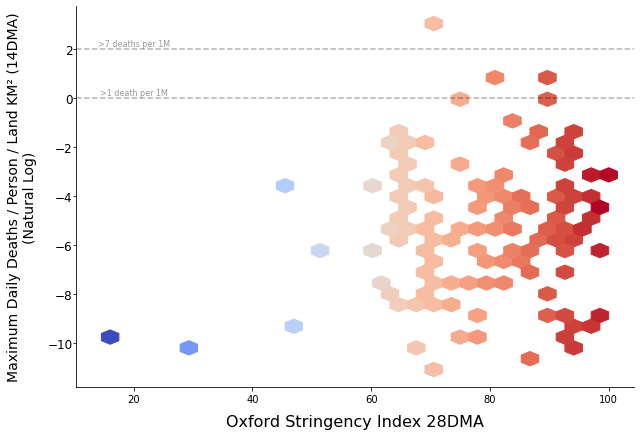

In [185]:
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2_lognat', 'comp_factor': 'strindex_dma', 
    'comp_factor_start': 'max',
    'fs_xticks': 12, 'fs_yticks': 12, 'fs_xlabel': 16, 'fs_ylabel': 14,
    'width': 10, 'height': 7, 'hexsize': 29,
}

kwargs['annotations'] = [
        [20, 2.25, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
        [20, 0.25, '>1 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ]
kwargs['hlines'] = [2, 0]

plt = casestudy.heatmap.make(**kwargs)

There are a few takeaways:    
* There isn't a clear correlation between stringency in the two weeks prior to peak and peak fatalities. 
* It does appear that the ***most*** stringent regions were perhaps less impacted than other regions.
* Each level of stringency has regions with high fatalities and low fatalities.
* Some of the outliers with the lowest stringency have very low death rates.
* There is exactly ***one*** region with _<80 strindex_ and max rate *>1 death per unit density*: **Russia**

In [186]:
test = ((casestudy.heatmap.df_hm.strindex_dma < 80) & (casestudy.heatmap.df_hm.deaths_new_dma_per_person_per_city_KM2_lognat > 0))
casestudy.heatmap.df_hm[test]

,region_id,region_name,deaths_new_dma_per_person_per_city_KM2_lognat,strindex_dma
120,477,Russia,3.055554,70.198929


### 28DMA Strindex on day of 3rd Fatality

The chart above perhaps only shows that Social Distancing has minimal impact once the infection rate is already well out-of-control. 

So now we consider the `strindex` 28DMA on the day of each region's 3rd confirmed fatality.

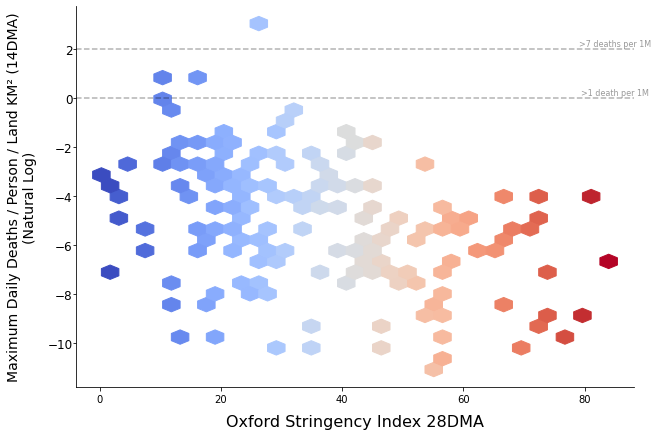

In [187]:
kwargs['comp_factor_start'] = 'start_hurdle'

kwargs['comp_category'] = 'deaths_new_dma_per_person_per_city_KM2_lognat'
kwargs['annotations'] = [
        [85, 2.25, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
        [85, 0.25, '>1 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ]
plt = casestudy.heatmap.make(**kwargs)

So if we look *much earlier* in the future, to the four weeks prior to the first death in the region, we can see a bit more of an effect. 

Regions with more stringent actions did seem to have lower death rates more often.

For example, we can see that **no** country with a **strindex <40** experienced  **>1 death per unit density.**

### Why?

So what to make of this? Obviously stricter social distancing earlier in the outbreak made for a better outcome. 

But how did a country know to enact social distancing early or not? Was it some kind of prescience? Quick decisions by government? Or something else?

### Add Color Map to Change In Transit Mobility

First, we can check actual adherence to these government decrees by overlaying a color-map of change in transit mobility by region. This will help support that it is Social Distancing, and not something else, that is creating the effect on fatality rate.

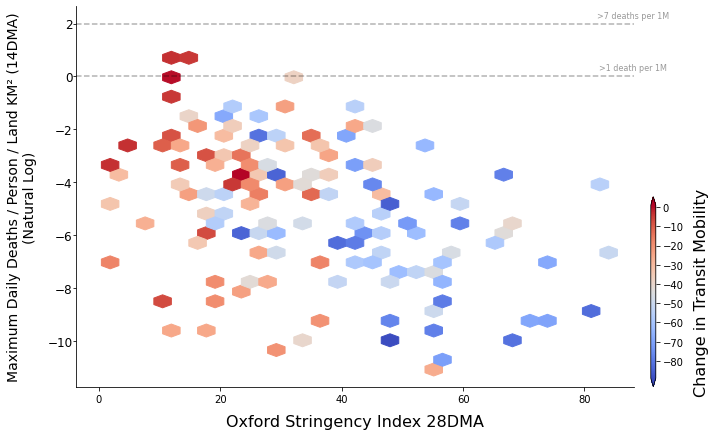

In [189]:
kwargs['color_factor'] = 'transit'
kwargs['color_factor_start'] = 'start_hurdle'

kwargs['comp_category'] = 'deaths_new_dma_per_person_per_city_KM2_lognat'
kwargs['annotations'] = [
        [-400, 99.75, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
        [-400, 72.45, '>1 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ]
plt = casestudy.heatmap.make(**kwargs)
strin_regions = casestudy.heatmap.df_hm.region_name

And what we see above is a very strong correlation between a change in `transit` mobility and the `strindex`. I am actually comforted to know that people took social distancing seriously.

### Strindex over time
So now we'll look at how the `strindex` for each region changes over time. 
* Did the least impacted regions with the higher `strindex` implement policies much sooner? 
* Did they hold them in place for longer?

We'll first look at the top 10 highest `strindex` in `df_hm` on the original timeline (beginning with `start_hurdle`)

In [190]:
from bokeh.palettes import Category20b

regions = list(strin_regions[:10])
kwargs = {
    'width': 825, 'height': 500,
    'palette_base': Category20b[20],
    'label_offsets': {
        'Taiwan': {'x_offset': 10, 'y_offset': 5},
    },
}
p = casestudy.comp_chart.make(regions=regions, comp_category='strindex', comp_type='multiline', **kwargs)
show(p)

The chart above looks useless but it does tell us that the days between the `start_hurdle` and the peak fatality rate was quite small for most of them. ***We will return to this later***

In the meantime, we can instantiate another `casestudy` object, this time eliminating the `start_hurdle`, allowing us to look all the way back to 01Jan2020.

In [191]:
regions = list(baseframe[(~baseframe['country'].isin(excluded_countries))] \
    .sort_values('population', ascending=False) \
    .region_name.unique())[:200]

casestudy = CaseStudy(
    baseframe, regions=regions, count_dma=14, factors=factors, 
    factor_dmas=factor_dmas, start_hurdle=0, start_factor='', lognat=True,
)
kwargs = {
    'width': 825, 'height': 500,
    'palette_base': Category20b[20],
    'label_offsets': {
        'Taiwan': {'x_offset': 10, 'y_offset': 5},
    },
}
regions = list(strin_regions[:10])
p = casestudy.comp_chart.make(regions=regions, comp_category='strindex', comp_type='multiline', **kwargs)
show(p)

This is yet again a pretty ugly graph, but it is striking that all these regions moved at relatively similar times to increase Social Distancing restraints.

So there are regions that had high `strindex` going into the `start_hurdle`. They must have been a pro-active bunch. They must have moved well in-advance of the other groups and, thereby, saw a lesser impact.

Can we determine if this occured? We will go outside of the `see19` package and use standard `matplotlib` and its `hexbin` chart. The `hexbin` is effecitvely a 2D histogram. The chart array is arranged into equal hexagonal areas, or "bins". The color of each bin is mapped to the number of datapoints that fall within the bin.

With our scale, the more datapoints in the bin, the brighter the bin will be.

We will reduce our dataset to just the 20 most stringent and 20 least stringent from the last `heatmap`.

If the more stringent regions are being proactive, we might expect to see the hex colors spread out more evenly, perhaps with a large group moving earlier.

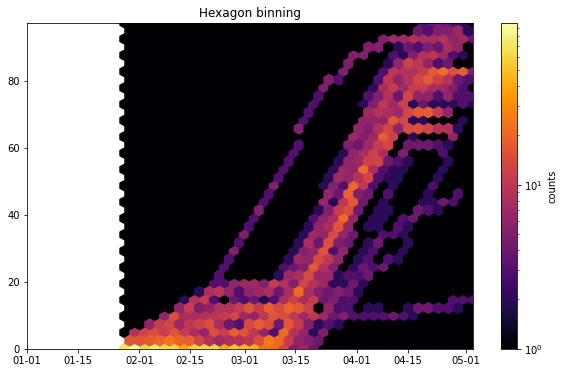

In [216]:
most_n_least = list(strin_regions.iloc[:20]) + list(strin_regions.iloc[-20:])
df_hex = casestudy.df[casestudy.df.region_name.isin(most_n_least)].copy(deep=True)

import pylab as pl
fig, ax = plt.subplots(figsize=(10, 6))
x = df_hex.date
x = pl.date2num(x)
y = df_hex.strindex_dma
hb = ax.hexbin(x, y, gridsize=35, cmap='inferno', bins='log')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.xaxis_date()
ax.xaxis.major.formatter.scaled[1.0] = "%m-%d"
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

In fact, what we see is that the vast majority of regions in the 40 region set increased stringency at essential the same time, beginning at around 15Mar2020.

So the regions with lower strindex at the time of max fatality did **not** have a first mover advantage.

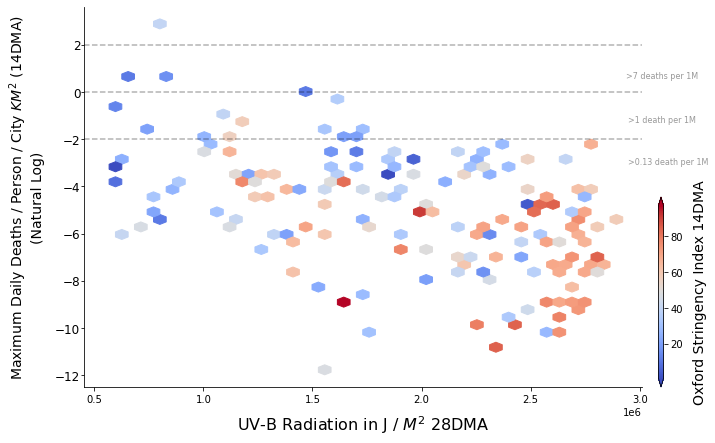

In [5]:
kwargs['comp_factor'] = 'uvb_dma'
kwargs['color_factor_start'] = 'start_hurdle'
kwargs['color_factor'] = 'strindex_dma'
kwargs['hexsize'] = 40
kwargs['hlines'] = [2, 0, -2]
kwargs['annotations'] = [
        [75, 170, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
        [75, 145, '>1 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
        [195, 122, '>0.13 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ]
plt = casestudy.heatmap.make(**kwargs)

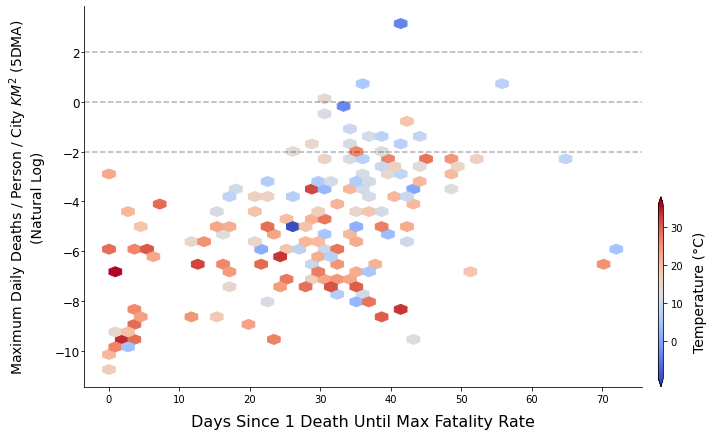

In [139]:
kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2', 'comp_factor': 'max_days', 'comp_factor_start': 'max',
    'fs_xticks': 12, 'fs_yticks': 12, 'fs_xlabel': 16, 'fs_ylabel': 14, 'fs_clabel': 14,
    'width': 10, 'height': 7, 'lognat': True, 'hexsize': 20,
}

kwargs['color_factor_start'] = 'start_hurdle'
kwargs['color_factor'] = 'temp'
kwargs['hexsize'] = 40
kwargs['hlines'] = [2, 0, -2]
kwargs['annotations'] = [
#         [75, 170, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [75, 145, '>1 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [195, 122, '>0.13 death per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ]
plt = casestudy.heatmap.make(**kwargs)

In [142]:
from bokeh.palettes import Category20b
regions = list(baseframe[baseframe.region_id == 304].sort_values(by='deaths', ascending=False).region_name.unique())[:10]

factors_with_dmas = MSMTS + ['strindex']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
factor_dmas['strindex'] = 14

casestudy = CaseStudy(
    baseframe, regions=regions, factors=factors_with_dmas, factor_dmas=factor_dmas,
    count_dma=5, start_hurdle=1, start_factor='deaths', min_days_from_start=1, min_deaths=1,
)
# 1) Pop. adjusted cumulative fatalities
# label_offsets = {
#     'Netherlands': {'x_offset': 5, 'y_offset': -20},
#     'United Kingdom': {'x_offset': -40, 'y_offset': 3},
#     'Iran': {'x_offset': -15, 'y_offset': 0},
#     'Lombardia': {'x_offset': 0, 'y_offset': -30},
# }
kwargs ={
    'filetitle': 'Cumulative Deaths of Top 10 Most Impacted Regions Excluding Hubei',
    'save_file': False,
    'legend': False,
    'width': 925,
    'label_offsets': label_offsets,
    'palette_base': Category20b[20]
}
p = casestudy.comp_chart.make(comp_category='deaths_new_dma_per_1M', comp_type='multiline', color_factor=[1], **kwargs)
show(p)

[1]


In [143]:
title = 'Max Daily Fatalities v UVB Radiation v Oxford Stringency Index'
subtitle = '*Average UVB radiation and Oxford Stringency Index for two weeks prior to day of 1st fatality'
note = '**Excludes mainland China'

kwargs = {
    'comp_category': 'deaths_new_dma_per_person_per_city_KM2',
    'comp_factor': 'A65PLUSB_%',
    'color_factor': 'uvb_dma',
    'color_factor_start': 'max',
    'annotations': [
#         [-10200, 206.6, title, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center',}],
#         [-10200, 200.2, subtitle, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-10200, 194.2, note, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-200, 68.1, '>54 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-200, 50.4, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-180, 41.5, '>2.7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ],
    'fs_xticks': 12, 'fs_yticks': 12,
    'fs_xlabel': 16, 'fs_ylabel': 14, 'fs_clabel': 14,
    'width': 12, 'height': 8,
    'lognat': True,
    'hlines': [2,0,-2],
    'hexsize': 34,
#     'save_file': True,    
#     'filename': 'Max Daily Fatalities vs Temperature (unscaled) as of April 29'
}
plt = casestudy.heatmap.make(**kwargs)

KeyError: 'A65PLUSB_%'

In [144]:
title = 'Max Daily Fatalities v UVB Radiation v Oxford Stringency Index'
subtitle = '*Average UVB radiation and Oxford Stringency Index for two weeks prior to day of 1st fatality'
note = '**Excludes mainland China'

kwargs = {
    'comp_category': 'deaths_new_dma_per_1M',
    'comp_factor': 'A65PLUSB_%',
    'color_factor': 'circul_%',
    'color_factor_start': 'max',
    'annotations': [
#         [-10200, 206.6, title, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center',}],
#         [-10200, 200.2, subtitle, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-10200, 194.2, note, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-200, 68.1, '>54 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-200, 50.4, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-180, 41.5, '>2.7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ],
    'fs_xticks': 12, 'fs_yticks': 12,
    'fs_xlabel': 16, 'fs_ylabel': 14, 'fs_clabel': 14,
    'width': 12, 'height': 8,
    'lognat': True,
    'hlines': [2,0,-2],
#     'save_file': True,    
#     'filename': 'Max Daily Fatalities vs Temperature (unscaled) as of April 29'
}
plt = casestudy.heatmap.make(**kwargs)

KeyError: 'A65PLUSB_%'

## TRAVEL!!!!! ##

In [ ]:

title = 'Max Daily Fatalities v UVB Radiation v Oxford Stringency Index'
subtitle = '*Average UVB radiation and Oxford Stringency Index for two weeks prior to day of 1st fatality'
note = '**Excludes mainland China'

kwargs = {
    'comp_category': 'deaths_new_dma_per_1M',
    'comp_factor': 'visitors_%',
    'color_factor': 'visitors_%',
    'annotations': [
#         [-10200, 206.6, title, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center',}],
#         [-10200, 200.2, subtitle, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-10200, 194.2, note, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-200, 68.1, '>54 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-200, 50.4, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-180, 41.5, '>2.7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ],
    'fs_xticks': 12, 'fs_yticks': 12,
    'fs_xlabel': 16, 'fs_ylabel': 14, 'fs_clabel': 14,
    'width': 12, 'height': 8,
    'lognat': True,
#     'color_range': (0, .1)
#     'save_file': True,    
#     'filename': 'Max Daily Fatalities vs Temperature (unscaled) as of April 29'
}
plt = casestudy.heatmap.make(**kwargs)

In [146]:
### GDP ###

In [ ]:
title = 'Max Daily Fatalities v UVB Radiation v Oxford Stringency Index'
subtitle = '*Average UVB radiation and Oxford Stringency Index for two weeks prior to day of 1st fatality'
note = '**Excludes mainland China'

kwargs = {
    'comp_category': 'gdp_%',
    'comp_factor': 'A75PLUSB_%',
#     'color_factor': 'gdp_%',
    'annotations': [
#         [-10200, 206.6, title, {'color': 'black', 'fontsize': 16, 'ha': 'left', 'va': 'center',}],
#         [-10200, 200.2, subtitle, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-10200, 194.2, note, {'color': 'black', 'fontsize': 12, 'ha': 'left', 'va': 'center', 'style': 'italic'}],
#         [-200, 68.1, '>54 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-200, 50.4, '>7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
#         [-180, 41.5, '>2.7 deaths per 1M', {'color': 'black', 'fontsize': 8, 'ha': 'center', 'va': 'center', 'alpha': .4,}],
    ],
    'fs_xticks': 12, 'fs_yticks': 12,
    'fs_xlabel': 16, 'fs_ylabel': 14, 'fs_clabel': 14,
    'width': 12, 'height': 8,
    'lognat': False,
#     'color_range': (0, .1)
#     'save_file': True,    
#     'filename': 'Max Daily Fatalities vs Temperature (unscaled) as of April 29'
}
plt = casestudy.heatmap.make(**kwargs)

# Next Section

Click on this link to go to the next notebook: [04 - Linear Regression](04%20-%20See19%20-%20Linear%20Regression.ipynb)